<a href="https://colab.research.google.com/github/nahumsa/DM-Reconstruction/blob/master/Reconstruct%20DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconstruction of a density matrix

### Import dependencies for Google Colab

In [0]:
! git clone https://github.com/nahumsa/DM-Reconstruction

In [0]:
!pip install qutip

In [0]:
% cd DM-Reconstruction/

##Import Dependencies

In [0]:
try:
  %tensorflow_version 2.x

except Exception:
  pass
  
import tensorflow as tf

#Set Random Seed for reproduction
tf.random.set_seed(1234)

import warnings
warnings.filterwarnings("ignore")

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import qutip

## Creating dataset

In [0]:
from Utils.Dataset import create_dataset

samples_train = 5000
states_train, measurements_train, labels_train = create_dataset(samples_train)

samples_test = 3000
states_test, measurements_test, labels_test = create_dataset(samples_test)

In [7]:
from Utils.Dataset import create_x

#Transforming in an np.array
X_train = np.array(create_x(measurements_train))
Y_train = np.array(labels_train)

X_test = np.array(create_x(measurements_test))
Y_test = np.array(labels_test)

print(f"Shape of the Training: \n X: {X_train.shape}")

Shape of the Training: 
 X: (5000, 15)


# Models

## VAE With Linear output and MSE loss function

### Choosing Running Folder

In [0]:
import os
# run params
SECTION = 'bvae'
RUN_ID = '0001'
DATA_NAME = 'Entanglement'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

### Defining the model

In [0]:
from Models.VAE_Keras import DenseVariationalAutoencoderKeras

#Parameters
input_dimension = (X_train.shape[1],)
encoder_dense = [512,256,128,52]
decoder_dense = [52,128,256, 512, X_train.shape[1]]
batch_norm = False
dropout = True
ZDIM = 5

#Defining the Beta-VAE
bvae = DenseVariationalAutoencoderKeras(input_dim = input_dimension
                                        , encoder_dense_units = encoder_dense
                                        , decoder_dense_units = decoder_dense
                                        , z_dim = ZDIM
                                        , use_batch_norm = batch_norm
                                        , use_dropout= dropout
                                        )

z_mu_b = bvae.encoder.predict(X_test)

### Training the model

In [0]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 500
BETA = 1
bvae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

#Callbacks 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_LR = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=5, 
                              verbose=1, 
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, min_lr=0)


callbacks = [reduce_LR]

# Training Parameters
BATCH_SIZE = 256
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

history = bvae.train( x_train = X_train
                    , y_train = X_train
                    , batch_size = BATCH_SIZE
                    , validation_data = (X_test, X_test)
                    , epochs = EPOCHS
                    , run_folder = RUN_FOLDER
                    , print_every_n_batches = PRINT_EVERY_N_BATCHES
                    , initial_epoch = INITIAL_EPOCH                    
                    , callbacks = callbacks
                    )

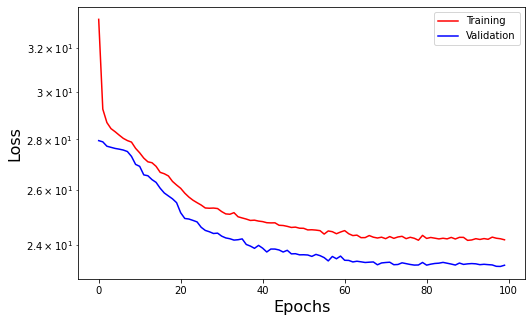

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

#Epochs
epochs = np.arange(INITIAL_EPOCH, EPOCHS, 1)

fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.set_yscale('log')
ax1.legend()
plt.show()

### Reconstruction plot

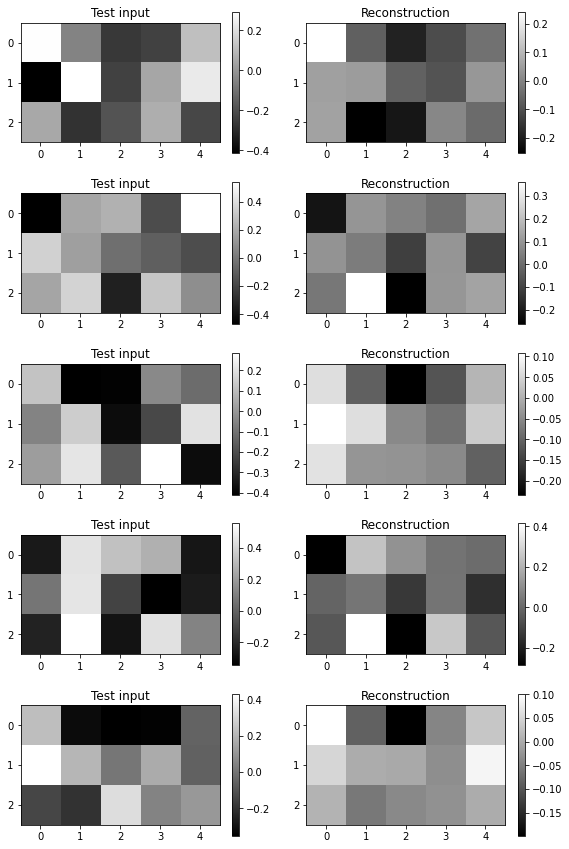

In [0]:
n_to_show = 5
example_idx = np.random.choice(range(len(X_test)), n_to_show)
example_images = X_test[example_idx]

z_points = bvae.encoder.predict(example_images)

reconst_images = bvae.decoder.predict(z_points)

plt.figure(figsize=(8, 12))
for i in range(n_to_show):

    plt.subplot(5, 2, 2*i + 1)    
    plt.imshow(example_images[i].reshape(3, 5), cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(reconst_images[i].reshape(3, 5), cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    
plt.tight_layout()

## Using Trace distance as a loss function

### Trace Distance example

In [0]:
from Utils.QutipUtils import DM_from_measurements
#Basis Measured
name_basis = ['I', 'X', 'Y', 'Z']
basis = [qutip.identity(2), qutip.sigmax(),qutip.sigmay(),qutip.sigmaz()]
mat_1 = DM_from_measurements(X_train[0],basis,name_basis)
mat_2 = DM_from_measurements(X_train[1],basis,name_basis)

In [23]:
qutip.metrics.tracedist(mat_1,mat_2)

2.024899208252566

### Building the model

In [0]:
from Models.VAE_Keras import DenseVariationalAutoencoderKeras
from keras.optimizers import Adam

class VaeTrace(DenseVariationalAutoencoderKeras): 
  def __init__(self
                , input_dim
                , encoder_dense_units
                , decoder_dense_units
                , z_dim
                , use_batch_norm = False
                , use_dropout= False
                ):
    
    super().__init__(input_dim
                      , encoder_dense_units
                      , decoder_dense_units
                      , z_dim
                      , use_batch_norm = use_batch_norm
                      , use_dropout= use_dropout
                    )
  
  def compile(self,
              learning_rate, 
              r_loss_factor, 
              Beta):
      """
      Compiling the network using r_loss as the categorical crossentropy
      and Adam optimizer. 
      Need to choose the learning rate, r_loss_factor
      in this case, and Beta for the Beta-VAE, if Beta = 1 then it is a VAE.
        
      Parameters
      ----------------------------------------------------------------------
      learning_rate: Learning Rate for gradient descent.
      r_loss_factor: Factor that multiplies the loss factor of the
                     reconstruction loss.
      Beta: Beta-VAE parameter that multiplies the KL-Divergence in order to
            disentangle the latent space of the model.
              
      """
        
      self.learning_rate = learning_rate        

      def trace_distance(y_true,y_pred):        
        name_basis = ['I', 'X', 'Y', 'Z']
        basis = [qutip.identity(2), qutip.sigmax(),qutip.sigmay(),qutip.sigmaz()]
        mat_1 = DM_from_measurements(y_true,basis,name_basis)
        mat_2 = DM_from_measurements(y_pred,basis,name_basis)
        return qutip.metrics.tracedist(mat_1,mat_2)

      ### COMPILATION
      def vae_r_loss(y_true, y_pred):
          r_loss = trace_distance(y_true, y_pred)
          return r_loss_factor * r_loss

      def vae_kl_loss(y_true, y_pred):
          kl_loss =  -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis = 1)
          return kl_loss

      def vae_loss(y_true, y_pred):
          r_loss = vae_r_loss(y_true, y_pred)
          kl_loss = vae_kl_loss(y_true, y_pred)
          return  r_loss + Beta*kl_loss

      optimizer = Adam(lr=learning_rate)
      self.model.compile(optimizer=optimizer, 
                         loss = vae_loss,  
                         metrics = [vae_r_loss, 
                                    vae_kl_loss]
                        )

In [0]:
#Parameters
input_dimension = (X_train.shape[1],)
encoder_dense = [512,256,128,52]
decoder_dense = [52,128,256, 512, X_train.shape[1]]
batch_norm = False
dropout = True
ZDIM = 3

#Defining the Beta-VAE
bvae = VaeTrace(input_dim = input_dimension
               , encoder_dense_units = encoder_dense
               , decoder_dense_units = decoder_dense
               , z_dim = ZDIM
               , use_batch_norm = batch_norm
               , use_dropout= dropout
               )

z_mu_b = bvae.encoder.predict(X_test)

### Training

In [40]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 500
BETA = 1
bvae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

#Callbacks 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_LR = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=5, 
                              verbose=1, 
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, min_lr=0)


callbacks = [reduce_LR]

# Training Parameters
BATCH_SIZE = 1#256
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

history = bvae.train( x_train = X_train
                    , y_train = X_train
                    , batch_size = BATCH_SIZE
                    , validation_data = (X_test, X_test)
                    , epochs = EPOCHS
                    , run_folder = RUN_FOLDER
                    , print_every_n_batches = PRINT_EVERY_N_BATCHES
                    , initial_epoch = INITIAL_EPOCH                    
                    , callbacks = callbacks
                    )

ValueError: ignored